In [5]:
#required moduls
import numpy as np
import cv2
import PIL.Image as Image
import os
import pathlib
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

In [6]:
#settings
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [7]:
train_dir='data/classifier_intersections/simulated_intersections'
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dir='data/classifier_intersections/test_sets/B'
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

val_dir='data/classifier_intersections/cross_validation_sets/ACD'
validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)





Found 10000 files belonging to 4 classes.
Found 500 files belonging to 4 classes.
Found 1500 files belonging to 4 classes.


In [8]:
#improve perf
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(0.2),
])

In [10]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input


In [11]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [12]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

16705208/16705208 [==============================] - 0s 0us/step


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [14]:
base_model.trainable = False


In [15]:
#effiecient arch
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(4,activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [18]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [20]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                             

In [21]:
len(model.trainable_variables)


2

In [22]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(validation_dataset)

47/47 [==============================] - 90s 2s/step - loss: 1.4194 - accuracy: 0.3040


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.42
initial accuracy: 0.30


In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=test_dataset)

Epoch 1/15
313/313 [==============================] - 660s 2s/step - loss: 0.9574 - accuracy: 0.6721 - val_loss: 1.1071 - val_accuracy: 0.5900
Epoch 2/15
313/313 [==============================] - 659s 2s/step - loss: 0.6182 - accuracy: 0.8568 - val_loss: 0.9916 - val_accuracy: 0.6400
Epoch 3/15
313/313 [==============================] - 664s 2s/step - loss: 0.4647 - accuracy: 0.9122 - val_loss: 0.9203 - val_accuracy: 0.6600
Epoch 4/15
313/313 [==============================] - 654s 2s/step - loss: 0.3717 - accuracy: 0.9345 - val_loss: 0.8748 - val_accuracy: 0.6860
Epoch 5/15
313/313 [==============================] - 678s 2s/step - loss: 0.3135 - accuracy: 0.9463 - val_loss: 0.8400 - val_accuracy: 0.7000
Epoch 6/15
313/313 [==============================] - 671s 2s/step - loss: 0.2727 - accuracy: 0.9554 - val_loss: 0.8221 - val_accuracy: 0.7080
Epoch 7/15
313/313 [==============================] - 666s 2s/step - loss: 0.2353 - accuracy: 0.9618 - val_loss: 0.8034 - val_accuracy: 0.7180

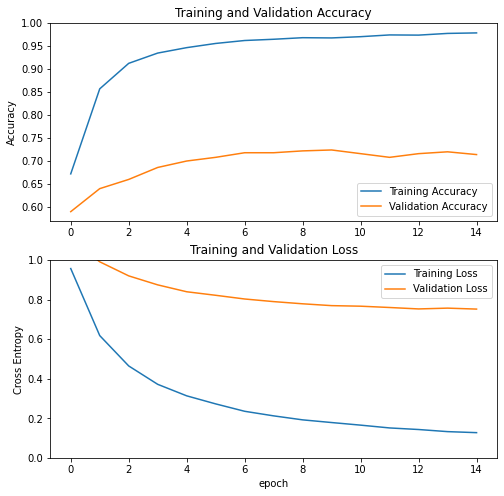

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('test_b')
plt.show()

In [26]:
base_model.trainable = True


In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 118

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  238


In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                             

In [30]:
len(model.trainable_variables)


109

In [31]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(validation_dataset ,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset)

Epoch 15/30
47/47 [==============================] - 216s 4s/step - loss: 0.6693 - accuracy: 0.7427 - val_loss: 0.5171 - val_accuracy: 0.8280
Epoch 16/30
47/47 [==============================] - 197s 4s/step - loss: 0.4179 - accuracy: 0.8567 - val_loss: 0.4223 - val_accuracy: 0.8600
Epoch 17/30
47/47 [==============================] - 198s 4s/step - loss: 0.2842 - accuracy: 0.8947 - val_loss: 0.3697 - val_accuracy: 0.8940
Epoch 18/30
47/47 [==============================] - 197s 4s/step - loss: 0.2008 - accuracy: 0.9367 - val_loss: 0.3428 - val_accuracy: 0.8940
Epoch 19/30
47/47 [==============================] - 198s 4s/step - loss: 0.1801 - accuracy: 0.9347 - val_loss: 0.3224 - val_accuracy: 0.9080
Epoch 20/30
47/47 [==============================] - 199s 4s/step - loss: 0.1681 - accuracy: 0.9400 - val_loss: 0.3468 - val_accuracy: 0.9000
Epoch 21/30
47/47 [==============================] - 199s 4s/step - loss: 0.1231 - accuracy: 0.9553 - val_loss: 0.3010 - val_accuracy: 0.9200
Epoch 

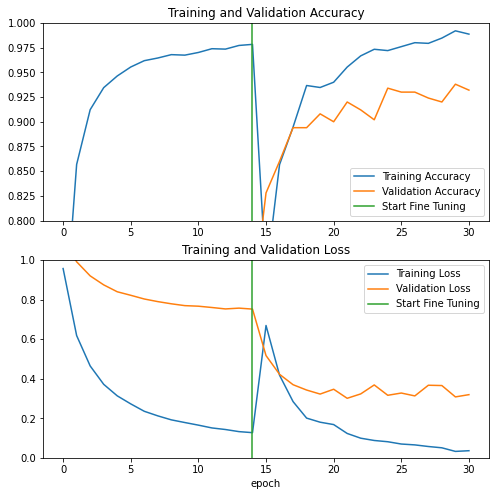

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('train_on_acd_test_on_b_with_fine_tuning')
plt.show()

In [33]:
train_dir='data/classifier_intersections/simulated_intersections'
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dir='data/classifier_intersections/test_sets/C'
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

val_dir='data/classifier_intersections/cross_validation_sets/ABD'
validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)





Found 10000 files belonging to 4 classes.
Found 500 files belonging to 4 classes.
Found 1500 files belonging to 4 classes.


16/16 [==============================] - 29s 2s/step


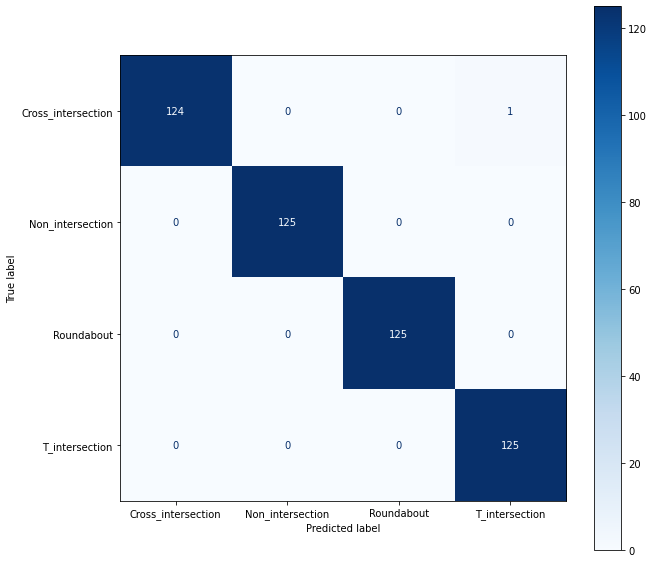

In [34]:
val_images =[]
true_labels = []
for image, label in test_dataset.unbatch():
    val_images.append(image)
    true_labels.append(label)
val_images = np.array(val_images)
true_labels = np.array(true_labels)  

predictions = model.predict(val_images)
predict_labels = predictions.argmax(axis=1)


intersections = test_dataset.class_names
cm = confusion_matrix(true_labels, predict_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=intersections)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.savefig('train_on_abd_val_on_c_with_con_matrix')
plt.show()

In [35]:
loss, acc = model.evaluate(val_images, true_labels, verbose=2)
print("Accuracy: {:5.2f}%".format(100 * acc))

16/16 - 28s - loss: 0.0118 - accuracy: 0.9980 - 28s/epoch - 2s/step
Accuracy: 99.80%


In [36]:
file=open('drive/MyDrive/project_codes/CLASSIFIERS/efficient_classifier/ACD/acc.txt','a')
file.write('model spec : \n')
file.write("accuracy of the model is : "+str(acc*100)+'\n')
file.write('loss of the model is : '+str(loss))
file.close()

!cp train_on_acd_val_on_d_with_con_matrix.png drive/MyDrive/project_codes/CLASSIFIERS/efficient_classifier/ACD/
!cp test_b.png drive/MyDrive/project_codes/CLASSIFIERS/efficient_classifier/ACD/
!cp train_on_acd_test_on_b_with_fine_tuning.png drive/MyDrive/project_codes/CLASSIFIERS/efficient_classifier/ACD/
# # save model
model.save('drive/MyDrive/project_codes/CLASSIFIERS/efficient_classifier/ACD/model.h5')